In [1]:
#!/usr/bin/env python

'''
DESCRIPTION
-----------
    LocalOutlierFactor with trained model

RETURN
------
    {DATASET}_lof_seen.png : png file
        Similarity scores of seen label
    {DATASET}_lof_seen.png : png file
        Similarity score of unseen label

EXPORTED FILE(s) LOCATION
-------------------------
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_seen.png
    ./reports/retrieval/{EXPERIMENT}/{DATASET}_lof_unseen.png
'''

# importing default libraries
import os, argparse, sys
# sys.path.append('./')
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import config as src

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')
import glob
TINY_SIZE = 8
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=12)    # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)     # fontsize of the tick labels
plt.rc('ytick', labelsize=TINY_SIZE)     # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

## MELANOMA

In [5]:
loc_output = src.define_folder('./reports/retrieval/exper_melanoma')
loc_output

PATH created!!
FOLDER information,  ./reports/retrieval/exper_melanoma/


'./reports/retrieval/exper_melanoma/'

In [6]:
df_query = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
df_reference = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')

In [7]:
X_query = df_query.iloc[:, :-1].values
y_ground_truth_query = df_query.iloc[:, -1:]

X_reference = df_reference.iloc[:, :-1].values
y_ground_truth_reference = df_reference.iloc[:, -1:]

# order_train = sorted(list(set(y_train.values.reshape(1,-1)[0])))

In [8]:
order_plot = list(set(y_ground_truth_reference.values.reshape(1,-1)[0]))
order_plot.extend(['Neg.cell'])
order_plot

['B.cell', 'Macrophage', 'T.CD8', 'T.CD4', 'NK', 'Neg.cell']

## FULL MODEL

In [11]:
model_ ='a1'
_, model_encoding = src.loading_model('./models/exper_melanoma/train_test_split/design_1_layer_signaling_reference_log1p_Adam.h5', -1)
model_encoding.summary()

Loaded model!! ./models/exper_melanoma/train_test_split/design_1_layer_signaling_reference_log1p_Adam.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 17994)]           0         
_________________________________________________________________
layer1 (Dense)               (None, 93)                1673535   
Total params: 1,673,535
Trainable params: 1,673,535
Non-trainable params: 0
_________________________________________________________________


In [12]:
encoding_query = model_encoding.predict(X_query)
encoding_reference = model_encoding.predict(X_reference)

In [13]:
print(encoding_query.shape)
print(encoding_reference.shape)

(3412, 93)
(2761, 93)


In [14]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(encoding_reference)

df_score_query = pd.concat([ y_ground_truth_query, pd.DataFrame(clf.score_samples(encoding_query), columns=['score'])], axis=1)
df_score_reference = pd.concat([ y_ground_truth_reference, pd.DataFrame(clf.score_samples(encoding_reference), columns=['score'])], axis=1)

# Calculated threshold value
threshold = np.mean(df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                    - df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
print('Threshold value from reference dataset, ', threshold)

Threshold value from reference dataset,  -1.3720625995181535


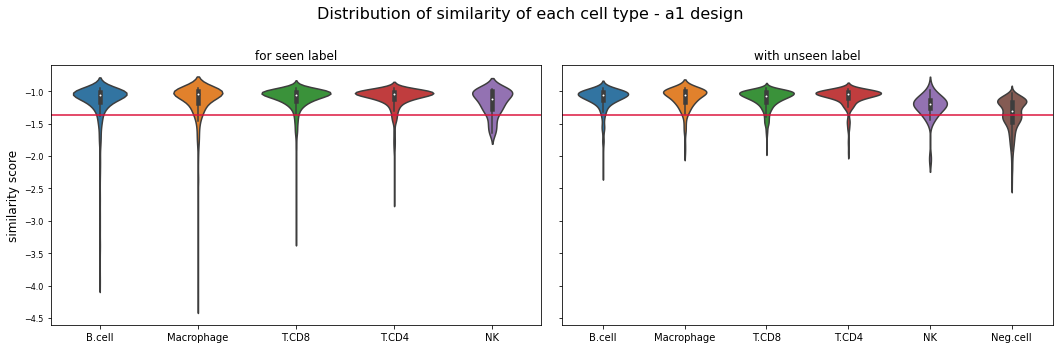

In [15]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_score_reference, ax=axes[0], order=order_plot[:-1])
sns.violinplot(x="cell_type", y="score", data=df_score_query, ax=axes[1], order=order_plot)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of each cell type - '+model_+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_violin_'+model_+'.png'), dpi=300, bbox_inches = 'tight')

In [16]:
df_score_query['threshold'] = 'above'
df_score_query.loc[df_score_query['score']<=threshold, 'threshold'] = 'below'
df_score_query.shape

(3412, 3)

In [17]:
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         226
           Macrophage     118
           NK              24
           Neg.cell      1322
           T.CD4          243
           T.CD8          488
below      B.cell          19
           Macrophage       8
           NK               4
           Neg.cell       906
           T.CD4           14
           T.CD8           40
dtype: int64


threshold  cell_type 
above      B.cell        92.244898
           Macrophage    93.650794
           NK            85.714286
           Neg.cell      59.335727
           T.CD4         94.552529
           T.CD8         92.424242
below      B.cell         7.755102
           Macrophage     6.349206
           NK            14.285714
           Neg.cell      40.664273
           T.CD4          5.447471
           T.CD8          7.575758
dtype: float64

In [18]:
df_score_query.groupby('threshold').size() / len(df_score_query)

threshold
above    0.709555
below    0.290445
dtype: float64

## LOGO

In [27]:
LOGO_encoding_q = pd.DataFrame()
LOGO_encoding_r = pd.DataFrame()
model_ ='a1'

for i_ in range(5):
    _, model_encoding = src.loading_model('./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_'+str(i_)+'_Adam.h5', -1)
    encoding_prediction_q = model_encoding.predict(X_query)
    encoding_prediction_r = model_encoding.predict(X_reference)
    LOGO_encoding_q = pd.concat([LOGO_encoding_q, pd.DataFrame(encoding_prediction_q)], axis=1)
    LOGO_encoding_r = pd.concat([LOGO_encoding_r, pd.DataFrame(encoding_prediction_r)], axis=1)

Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_0_Adam.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_1_Adam.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_2_Adam.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_3_Adam.h5
Loaded model!! ./models/exper_melanoma/LeaveOneGroupOut/design_1_layer_signaling_reference_log1p_4_Adam.h5


In [28]:
clf = LocalOutlierFactor(novelty=True)
clf.fit(LOGO_encoding_r)

df_score_query = pd.concat([ y_ground_truth_query, pd.DataFrame(clf.score_samples(LOGO_encoding_q), columns=['score'])], axis=1)
df_score_reference = pd.concat([ y_ground_truth_reference, pd.DataFrame(clf.score_samples(LOGO_encoding_r), columns=['score'])], axis=1)

# Calculated threshold value
threshold = np.mean(df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                    - df_score_reference.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
print('Threshold value from reference dataset, ', threshold)

Threshold value from reference dataset,  -1.3990370883261416


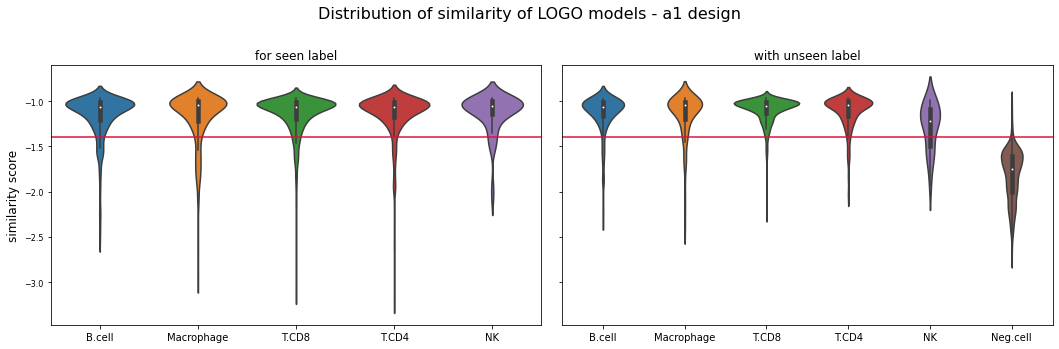

In [31]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(15,5))#, dpi=100)
sns.violinplot(x="cell_type", y="score", data=df_score_reference, ax=axes[0], order=order_plot[:-1])
sns.violinplot(x="cell_type", y="score", data=df_score_query, ax=axes[1], order=order_plot)
axes[0].axhline(threshold, color='crimson')
axes[1].axhline(threshold, color='crimson')
axes[0].set_title('for seen label')
axes[1].set_title('with unseen label')
axes[0].set(xlabel='', ylabel='similarity score')
axes[1].set(xlabel='', ylabel='')
fig.suptitle('Distribution of similarity of LOGO models - '+model_+' design')
plt.tight_layout()
plt.savefig(os.path.join(loc_output, 'similarity_score_LOGO_violin_'+model_+'.png'), dpi=300, bbox_inches = 'tight')

In [24]:
df_score_query['threshold'] = 'above'
df_score_query.loc[df_score_query['score']<=threshold, 'threshold'] = 'below'
df_score_query.shape

(3412, 3)

In [26]:
#A2
print(df_score_query.groupby(['threshold', 'cell_type']).size()) #/ df_score_query.groupby('cell_type').size()
(df_score_query.groupby(['threshold', 'cell_type']).size() / df_score_query.groupby('cell_type').size())*100

threshold  cell_type 
above      B.cell         222
           Macrophage     111
           NK              20
           Neg.cell        49
           T.CD4          237
           T.CD8          509
below      B.cell          23
           Macrophage      15
           NK               8
           Neg.cell      2179
           T.CD4           20
           T.CD8           19
dtype: int64


threshold  cell_type 
above      B.cell        90.612245
           Macrophage    88.095238
           NK            71.428571
           Neg.cell       2.199282
           T.CD4         92.217899
           T.CD8         96.401515
below      B.cell         9.387755
           Macrophage    11.904762
           NK            28.571429
           Neg.cell      97.800718
           T.CD4          7.782101
           T.CD8          3.598485
dtype: float64